[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nkeriven/ensta-mt12/blob/main/notebooks/08_RNN_LSTM/N2_LSTM_example.ipynb)

LSTM example on forecasting a scalar temperature value from a vector of past values. 

This Notebook is largely inspired from 
https://www.tensorflow.org/tutorials/structured_data/time_series
which runs under TensorFlow2. 



In [1]:
# import keras
# if tensorflow2, replace by
import os

import numpy as np
import pandas as pd
import tensorflow.keras as keras

# to insure reproductability of different runs
np.random.seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)

# if tensorflow2, replace the two lines above by
from tensorflow import random

random.set_seed(2)

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

This tutorial uses a weather time series dataset recorded by the Max Planck Institute for Biogeochemistry.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.

In [2]:
# zip_path = keras.utils.get_file(
#    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
#    fname='jena_climate_2009_2016.csv.zip', extract= True)
# csv_path, _ = os.path.splitext(zip_path)
# csv_path
# df = pd.read_csv(csv_path)
filename = "jena_climate_2009_2016.csv"
df = pd.read_csv(filename) #This is a pandas DataFrame
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


An observation is recorded every 10 minutes. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations.

Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use a set of preceding N observations. Thus, you would create a window containing the last N points. For example, 5 days of observation correspond to 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.


##  Forecast a univariate time series

Here, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.


In [3]:
# Extract univariate time series
Temp = df["T (degC)"]
Temp.index = df["Date Time"]
print(f"the time series contains {Temp.shape[0]} sample")
print("\n First five rows:")
Temp.head()

the time series contains 420551 sample

 First five rows:


Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<AxesSubplot:xlabel='Date Time'>], dtype=object)

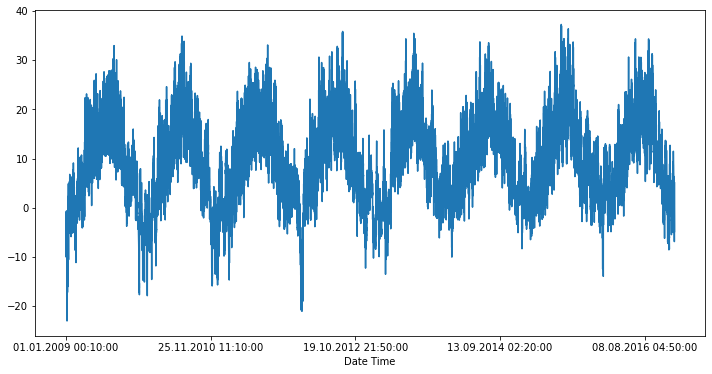

In [4]:
# plot time series
Temp.plot(subplots=True, figsize=(12, 6))

### Rescaling

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1 (if sigmoid activation) or -1 to +1 (if tanh), also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.


In [5]:
data = np.array(Temp.values, dtype='float32')[:,np.newaxis]
data.shape

(420551, 1)

In [6]:
from sklearn.preprocessing import MinMaxScaler

data = np.array(Temp.values, dtype='float32')[:,np.newaxis]

#data = np.reshape(Temp.values, (420551, 1))
#data = data.astype("float32")

scaler = MinMaxScaler(feature_range=(-1, 1))  # compatiblity with choice activation=tanh
data_sc = scaler.fit_transform(data)

print(data[:5,])
scaler.inverse_transform(data_sc)[:5]

[[-8.02]
 [-8.41]
 [-8.51]
 [-8.31]
 [-8.27]]


array([[-8.02    ],
       [-8.409999],
       [-8.51    ],
       [-8.31    ],
       [-8.27    ]], dtype=float32)

#### Exercise
Implement the minmaxscaler yourself, verify your result

### Define training and testing sets

In [7]:
# split into train and test sets
train_size = 300000
test_size = len(data_sc) - train_size
train, test = data_sc[0:train_size, :], data_sc[train_size : len(data_sc), :]
print(len(train), len(test))

300000 120551


### Question
why don't we use the train/test splitting function from sklearn ?

### Rearrange data into a matrix forms

We need to create a dataset of $p$-dimensional samples and labels. Each time step $i$ will correspond to a sample: the previous time steps $[x_{i-p+1}, \ldots, x_{i-1}, x_i]$ are used as the sample, from which we want to predict some future value $x_{i+\ell}$.

The following function create such a data matrix. $p$ is called look_back, and $\ell$ is called forecast.

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, forecast=0):
    dataX, dataY = [], []
    for i in range(look_back, len(dataset) - forecast):  # current time index is i
        a = dataset[i-look_back : i, 0]
        dataX.append(a)
        dataY.append(
            dataset[i + forecast, 0]
        )  # from a, predicts at time index i
    return np.array(dataX), np.array(dataY)

On the example below, only 20 past observations are used to predict future  temperature value 6 samples ahead (This correspond to a 1 hour)

In [9]:
# reshape into X=t and Y=t+1
look_back = 20
forecast = 6
trainX, trainY = create_dataset(train, look_back, forecast)
testX, testY = create_dataset(test, look_back, forecast)
trainX.shape
trainY = trainY.reshape((-1, 1))
testY = testY.reshape((-1, 1))
print(f'Number of training samples:{trainX.shape[0]}, number of test samples:{testX.shape[0]}')

Number of training samples:299974, number of test samples:120525


### The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [10]:
# reshape input to be [samples, time steps, features]
trainX = trainX[:,:,np.newaxis]
testX = testX[:,:,np.newaxis]
trainX.shape

(299974, 20, 1)

In [11]:
# May be useful to test the code on shorter data set...

# trainX=trainX[:200,:,:]
# trainY=trainY[:200]
# testX=testX[:200,:,:]
# testY=testY[:200]
# trainY.shape

In [12]:
# Save the original datasets
trainX_orig, trainY_orig, testX_orig, testY_orig,= trainX, trainY, testX, testY

## Learn a LSTM model 

A batch method is used during the optization phase. The size of the batches is set here to 256 samples (256 consecutive -in time- vectors X of look_back (=20) numerical values, and correponding outputs Y.

The cell states are initialized at random. Obviously, the paramater shuffle has to be set to shuffle=False, as shuffling the data would destroy all time dependencies that are seeked by the LSTM. 

As by default, cell states are not reinitialized after an epoch, we prefer here to force these states to reinitilaize afetr each epoch.
(Cell states are reinitialized, but not the internal networks -remind that there are 4 of them in a LSTM- are kept to  their current value.




In [13]:
#import math

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

size_of_batch = 256

# adapt length of trainX and trainY to be divisible by size_of_batch
L = int(len(trainX) / 256) * 256
trainX = trainX_orig[:L, :, :]
trainY = trainY_orig[:L]

trainDate = Temp.index[:L]
df_train_scaled = pd.DataFrame(index=trainDate)
df_train_scaled["Actual"] = trainY

In [14]:
trainDate

Index(['01.01.2009 00:10:00', '01.01.2009 00:20:00', '01.01.2009 00:30:00',
       '01.01.2009 00:40:00', '01.01.2009 00:50:00', '01.01.2009 01:00:00',
       '01.01.2009 01:10:00', '01.01.2009 01:20:00', '01.01.2009 01:30:00',
       '01.01.2009 01:40:00',
       ...
       '11.09.2014 11:20:00', '11.09.2014 11:30:00', '11.09.2014 11:40:00',
       '11.09.2014 11:50:00', '11.09.2014 12:00:00', '11.09.2014 12:10:00',
       '11.09.2014 12:20:00', '11.09.2014 12:30:00', '11.09.2014 12:40:00',
       '11.09.2014 12:50:00'],
      dtype='object', name='Date Time', length=299776)

In [15]:
nb_epochs = 10
neurons = 8  # size of both hidden stat (h) and cell state (C)
# create and fit the LSTM network
model = Sequential()
model.add(
    LSTM(
        neurons,
        activation="tanh",
        recurrent_activation="sigmoid",
        batch_input_shape=(size_of_batch, trainX.shape[1], 1),
        stateful=True,
    )
)
model.add(Dense(1))
# use stochastic gradient optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (256, 8)                  320       
_________________________________________________________________
dense (Dense)                (256, 1)                  9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


2022-02-02 16:46:38.793815: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-02 16:46:38.794028: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-02 16:46:38.794254: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


It is usual to reset the hidden states of RNN between epochs (technically, we should even do it between batches). See https://adgefficiency.com/tf2-lstm-hidden/

In [16]:
nb_epochs = 5
# Train the network
for i in range(nb_epochs):
    model.fit(
        trainX, trainY, epochs=1, batch_size=size_of_batch, verbose=1, shuffle=False
    )
    model.reset_states()

2022-02-02 16:46:38.987005: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-02 16:46:39.005456: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2099940000 Hz


1171/1171 [==============================] - 25s 21ms/step - loss: 0.0010


In [17]:
# make predictions
trainPredict = model.predict(trainX, batch_size=size_of_batch)
df_train_scaled["Predict"] = trainPredict

# adapt length of trainX and trainY to size_of_batch
L_test = int(len(testX) / 256) * 256
testX = testX_orig[:L_test, :, :]
testY = testY_orig[:L_test]

testDate = Temp.index[train_size : train_size + L_test]
testPredict = model.predict(testX, batch_size=size_of_batch)
df_test_scaled = pd.DataFrame(index=testDate)
df_test_scaled["Actual"] = testY
df_test_scaled["Predict"] = testPredict

In [18]:
print(testDate)

Index(['13.09.2014 02:20:00', '13.09.2014 02:30:00', '13.09.2014 02:40:00',
       '13.09.2014 02:50:00', '13.09.2014 03:00:00', '13.09.2014 03:10:00',
       '13.09.2014 03:20:00', '13.09.2014 03:30:00', '13.09.2014 03:40:00',
       '13.09.2014 03:50:00',
       ...
       '30.12.2016 08:00:00', '30.12.2016 08:10:00', '30.12.2016 08:20:00',
       '30.12.2016 08:30:00', '30.12.2016 08:40:00', '30.12.2016 08:50:00',
       '30.12.2016 09:00:00', '30.12.2016 09:10:00', '30.12.2016 09:20:00',
       '30.12.2016 09:30:00'],
      dtype='object', name='Date Time', length=120320)


<AxesSubplot:xlabel='Date Time'>

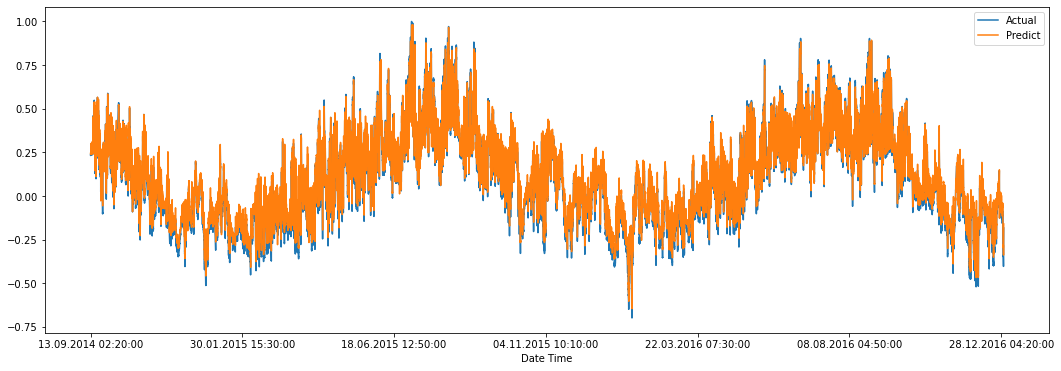

In [19]:
import matplotlib.pyplot as plt

df_test_scaled.plot(subplots=False, figsize=(18, 6))

## Back in the original space
To evaluate RMSE performance and visualize the results in the original space, one needs to rescale back the data to their original scale. 

<AxesSubplot:xlabel='Date Time'>

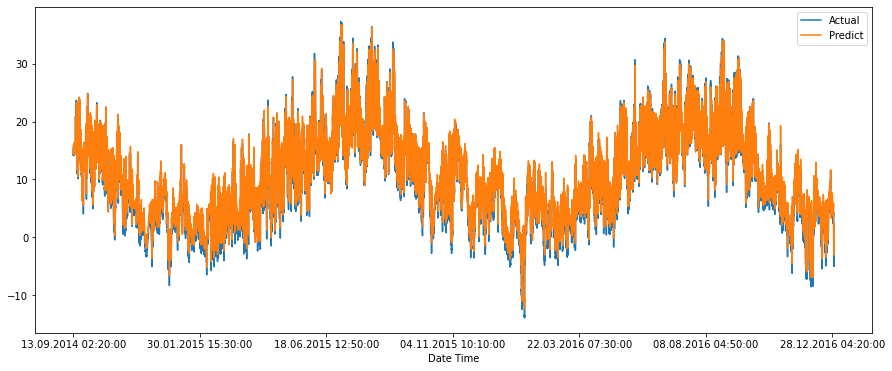

In [20]:
# invert predictions
trainPredict = scaler.inverse_transform(df_train_scaled["Predict"].values.reshape(-1, 1))
trainY = scaler.inverse_transform(df_train_scaled["Actual"].values.reshape(-1, 1))
testPredict = scaler.inverse_transform(df_test_scaled["Predict"].values.reshape(-1, 1))
testY = scaler.inverse_transform(df_test_scaled["Actual"].values.reshape(-1, 1))

df_test = pd.DataFrame(index=testDate)
df_test["Actual"] = testY
df_test["Predict"] = testPredict
df_test.plot(subplots=False, figsize=(15, 6))

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
r2_trainScore = r2_score(trainY, trainPredict)
print(
    "Train Score:\tRMSE is {:.2f} (°C),\t R^2 is {:2.1f}%".format(
        trainScore, 100 * r2_trainScore
    )
)
testScore = np.sqrt(mean_squared_error(testY, testPredict))
r2_testScore = r2_score(testY, testPredict)
print(
    "Test Score:\tRMSE is {:.2f} (°C),\t R^2 is {:2.1f}%".format(testScore, 100 * r2_testScore)
)

Train Score:	RMSE is 1.23 (°C),	 R^2 is 98.0%
Test Score:	RMSE is 1.19 (°C),	 R^2 is 97.7%
